# Milestone 3: Text analysis


In [23]:
%matplotlib inline

import os
import nltk
import json
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from unidecode import unidecode
from nltk.corpus import stopwords
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score


plt.style.use('ggplot')

## Grabbing the data

In [3]:
raw = pd.read_json('../../data/themoviedb-5k-sample-4-15-2017.json')
print(raw.shape)
raw.head()

(5000, 29)


,adult,backdrop_path,belongs_to_collection,budget,cast,crew,genre_ids,genres,homepage,id,...,revenue,reviews,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,None,None,0,[],"[{u'name': u'Bobby Sheehan', u'department': u'...",[99],"[{u'name': u'Documentary', u'id': 99}]",https://www.boughtmovie.net,328380,...,0,[],93.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,,Bought,False,0.0,0
1,False,None,None,0,[],"[{u'name': u'Nancy Donnelly', u'department': u...",[99],"[{u'id': 99, u'name': u'Documentary'}]",,112052,...,0,[],60.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,,Egypt Underworld,False,3.8,2
2,False,/jWgtb7CRy3jWoXiz0IK352MG8b5.jpg,None,0,"[{u'name': u'Zhang Jin', u'character': u'Chau ...","[{u'name': u'Douglas Kung Cheung-Tak', u'depar...",[28],"[{u'id': 28, u'name': u'Action'}]",http://www.hkcinemagic.com/en/movie.asp?id=6627,201706,...,0,[],1.0,"[{u'name': u'广州话 / 廣州話', u'iso_639_1': u'cn'},...",Released,,Chinese Heroes,False,0.0,0
3,False,None,None,0,"[{u'name': u'Erika Eleniak', u'character': u'J...","[{u'name': u'Brian Katkin', u'department': u'D...","[28, 18, 53]","[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",,61803,...,0,[],92.0,"[{u'name': u'English', u'iso_639_1': u'en'}]",Released,he quake of the century... get ready to rumble...,Shakedown,False,3.0,2
4,False,/sHH63HMAQsKLl0vpJ6AxulmkL92.jpg,None,0,"[{u'name': u'Kay Panabaker', u'character': u'J...","[{u'name': u'Kevin Tancharoen', u'department':...","[10402, 35, 18, 10749]","[{u'id': 10402, u'name': u'Music'}, {u'id': 35...",,28665,...,0,[],107.0,"[{u'iso_639_1': u'en', u'name': u'English'}]",Released,,Fame,False,5.4,109


In [4]:
# Keeping only genres, overviews, and reviews
raw = raw[['genres', 'reviews', 'overview']].copy()
print(raw.shape)
raw.head()

(5000, 3)


,genres,reviews,overview
0,"[{u'name': u'Documentary', u'id': 99}]",[],Modern industrialization is no longer about st...
1,"[{u'id': 99, u'name': u'Documentary'}]",[],The documentary is an analysis of the fascinat...
2,"[{u'id': 28, u'name': u'Action'}]",[],A good-natured kung fu kid gets caught up in c...
3,"[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",[],In Los Angeles a deadly plague called the 'Pan...
4,"[{u'id': 10402, u'name': u'Music'}, {u'id': 35...",[],"An updated version of the 1980 musical, which ..."


## Converting `genres` to bigrams

In [5]:
all_bigrams_ever = []

def bigrams(row):
    return zip(row['genre_lists'], row['genre_lists'][1:])

def col_for_each_bigram(row):
    for bigram in row['genre_bigrams']:            
        all_bigrams_ever.append(tuple(sorted(bigram)))
    return row

def popular_bigram(row):
    for k in row['genre_bigrams']:
        if bigram_frequency[k] <= 50 and len(row['genre_lists']) != 1:
            row['popular_bigram'] = 'Other'
        elif k in OrderedDict(bigram_frequency.most_common()).keys() and row['popular_bigram'] != k:
            row['popular_bigram'] = k
    if len(row['genre_lists']) == 1:
        row['popular_bigram'] = tuple(row['genre_lists'])
    return row
                
raw['genre_lists'] = raw.apply(lambda x: [y['name'] for y in x['genres']], axis = 1)
raw['genre_bigrams'] = raw.apply(lambda x: bigrams(x), axis = 1)
raw['popular_bigram'] = np.nan
raw = raw.apply(lambda x: col_for_each_bigram(x), axis = 1)
bigram_frequency = Counter(all_bigrams_ever)
raw = raw.apply(lambda x: popular_bigram(x), axis = 1)
raw.head()

,genres,reviews,overview,genre_lists,genre_bigrams,popular_bigram
0,"[{u'name': u'Documentary', u'id': 99}]",[],Modern industrialization is no longer about st...,[Documentary],[],"(Documentary,)"
1,"[{u'id': 99, u'name': u'Documentary'}]",[],The documentary is an analysis of the fascinat...,[Documentary],[],"(Documentary,)"
2,"[{u'id': 28, u'name': u'Action'}]",[],A good-natured kung fu kid gets caught up in c...,[Action],[],"(Action,)"
3,"[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",[],In Los Angeles a deadly plague called the 'Pan...,"[Action, Drama, Thriller]","[(Action, Drama), (Drama, Thriller)]","(Drama, Thriller)"
4,"[{u'id': 10402, u'name': u'Music'}, {u'id': 35...",[],"An updated version of the 1980 musical, which ...","[Music, Comedy, Drama, Romance]","[(Music, Comedy), (Comedy, Drama), (Drama, Rom...","(Drama, Romance)"


In [6]:
genre_frequency = raw['popular_bigram'].value_counts()
genre_frequency[-10:]

(Western,)            19
(Adventure, Drama)    16
(Fantasy,)            15
(Crime,)              13
(Adventure,)          12
(Foreign,)             6
(Mystery,)             4
(TV Movie,)            3
(War,)                 1
(History,)             1
Name: popular_bigram, dtype: int64

In [7]:
# Dropping "rare" movies (i.e. with a y < 1% of sample N)
rare_genres = genre_frequency[genre_frequency < (raw.shape[0]*0.01)].index
raw['drop'] = raw.apply(lambda x: 1 if x['popular_bigram'] in rare_genres else 0, axis = 1)
raw['drop'].value_counts()

0    4214
1     786
Name: drop, dtype: int64

In [8]:
# I'll drop movies with 'rare' genres
df = raw[(raw['drop'] == 0) | (raw['popular_bigram'] == 'Other')].copy()
df = df[df['popular_bigram'] != 'Other'].copy()
raw.shape, df.shape

((5000, 7), (2739, 7))

The final $y$ I'll be predicting is `popular_bigram`. 

## Converting `overview` and `reviews` to word-frequency vectors

In [9]:
# I realized that sometimes 'overview' was in my top words list; renaming it here 'protects' it
df.rename(columns={'overview': 'movie_overview'}, inplace=True)

stops = set(nltk.corpus.stopwords.words('english'))
all_words_ever = []

def add_cols_for_all_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if len(word) > 2 and unidecode(word.lower()) not in stops]
        all_words_ever.extend(words)
    return row

def parse_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if word.lower() in top_words]
        for word in words:
            row[unidecode(word)] += 1        
    return row

In [10]:
df['review_text'] = df.apply(lambda row: [x['content'] for x in row['reviews']], axis = 1)
df.head()

,genres,reviews,movie_overview,genre_lists,genre_bigrams,popular_bigram,drop,review_text
0,"[{u'name': u'Documentary', u'id': 99}]",[],Modern industrialization is no longer about st...,[Documentary],[],"(Documentary,)",0,[]
1,"[{u'id': 99, u'name': u'Documentary'}]",[],The documentary is an analysis of the fascinat...,[Documentary],[],"(Documentary,)",0,[]
2,"[{u'id': 28, u'name': u'Action'}]",[],A good-natured kung fu kid gets caught up in c...,[Action],[],"(Action,)",0,[]
3,"[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",[],In Los Angeles a deadly plague called the 'Pan...,"[Action, Drama, Thriller]","[(Action, Drama), (Drama, Thriller)]","(Drama, Thriller)",0,[]
4,"[{u'id': 10402, u'name': u'Music'}, {u'id': 35...",[],"An updated version of the 1980 musical, which ...","[Music, Comedy, Drama, Romance]","[(Music, Comedy), (Comedy, Drama), (Drama, Rom...","(Drama, Romance)",0,[]


In [11]:
df = df.apply(lambda x: add_cols_for_all_words(x), axis = 1)
len(all_words_ever), len(set(all_words_ever))

(84019, 18506)

In [12]:
# I'll use the top N words
N = 500
top_words = [word[0] for word in Counter(all_words_ever).most_common(N)]
len(top_words)

500

In [13]:
for word in top_words:
    df[unidecode(word)] = 0

df = df.apply(lambda x: parse_words(x), axis = 1)
    
print(df.shape)
df.head()

(2739, 508)


,genres,reviews,movie_overview,genre_lists,genre_bigrams,popular_bigram,drop,review_text,life,one,...,everyone,biggest,took,feature,leading,became,question,include,looks,played
0,"[{u'name': u'Documentary', u'id': 99}]",[],Modern industrialization is no longer about st...,[Documentary],[],"(Documentary,)",0,[],0,0,...,0,0,0,0,0,0,0,0,0,0
1,"[{u'id': 99, u'name': u'Documentary'}]",[],The documentary is an analysis of the fascinat...,[Documentary],[],"(Documentary,)",0,[],0,0,...,0,0,0,0,0,0,0,0,0,0
2,"[{u'id': 28, u'name': u'Action'}]",[],A good-natured kung fu kid gets caught up in c...,[Action],[],"(Action,)",0,[],0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[{u'id': 28, u'name': u'Action'}, {u'id': 18, ...",[],In Los Angeles a deadly plague called the 'Pan...,"[Action, Drama, Thriller]","[(Action, Drama), (Drama, Thriller)]","(Drama, Thriller)",0,[],0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[{u'id': 10402, u'name': u'Music'}, {u'id': 35...",[],"An updated version of the 1980 musical, which ...","[Music, Comedy, Drama, Romance]","[(Music, Comedy), (Comedy, Drama), (Drama, Rom...","(Drama, Romance)",0,[],0,0,...,0,0,0,0,0,0,0,0,0,0


## Fitting the model
I'll use a Naive Bayes multinomial classifier. We have to predict 28 unique genre bigrams. We're using 500 "top word" frequency vectors. 

In [44]:
X = df[df.columns[-N:]]
y = df['popular_bigram']
y = y.apply(lambda x: str(x))
X.shape, y.shape

((2739, 500), (2739,))

In [45]:
clf = MultinomialNB()

In [92]:
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: {:0.2f} (+/- {:0.2f})%".format(scores.mean(), scores.std() * 2))

Accuracy: 0.39 (+/- 0.04)%


We have 16 unique genres which we are predicting. A random classifier would thus predict around 6% correctly. At present, we're able to predict with around 39% accuracy, using the top 500 words (by frequency) in film summary overviews.

### Confusion matrix

In [47]:
train = df.sample(frac = 0.8)
test = df.drop(train.index)
train.shape, test.shape

((2191, 508), (548, 508))

In [52]:
X_train = train[train.columns[-N:]]
X_test = test[test.columns[-N:]]
y_train = train['popular_bigram'].apply(lambda x: str(x))
y_test = test['popular_bigram'].apply(lambda x: str(x))
X_train.shape, X_test.shape

((2191, 500), (548, 500))

In [87]:
fitted = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = fitted.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

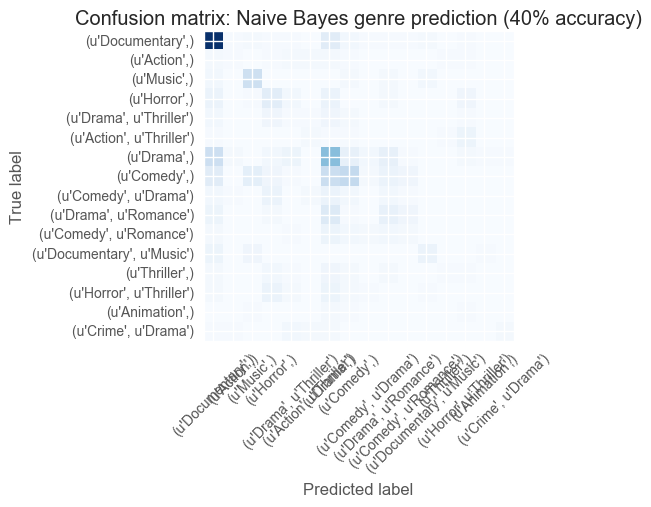

In [91]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(y_test.nunique())
plt.xticks(tick_marks, y_test.unique(), rotation=45)
plt.yticks(tick_marks, y_test.unique())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: Naive Bayes genre prediction ({:.0f}% accuracy)'.format(score*100))
plt.show()

In [99]:
y_test.value_counts()

(u'Documentary',)             123
(u'Drama',)                    97
(u'Comedy',)                   84
(u'Horror',)                   32
(u'Drama', u'Romance')         32
(u'Music',)                    30
(u'Comedy', u'Drama')          25
(u'Horror', u'Thriller')       19
(u'Comedy', u'Romance')        18
(u'Drama', u'Thriller')        16
(u'Thriller',)                 16
(u'Documentary', u'Music')     16
(u'Action',)                   13
(u'Crime', u'Drama')           11
(u'Action', u'Thriller')       11
(u'Animation',)                 5
Name: popular_bigram, dtype: int64

In [103]:
pd.Series(y_pred).value_counts()

(u'Documentary',)             165
(u'Drama',)                   125
(u'Comedy',)                   54
(u'Horror',)                   40
(u'Music',)                    37
(u'Drama', u'Romance')         34
(u'Drama', u'Thriller')        20
(u'Horror', u'Thriller')       16
(u'Comedy', u'Romance')        13
(u'Documentary', u'Music')     12
(u'Action', u'Thriller')        9
(u'Comedy', u'Drama')           9
(u'Action',)                    6
(u'Crime', u'Drama')            3
(u'Thriller',)                  3
(u'Animation',)                 2
dtype: int64

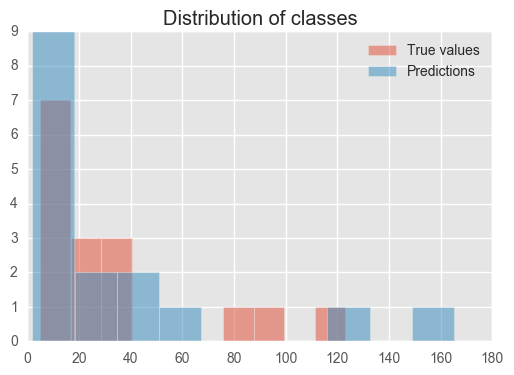

In [109]:
plt.hist(y_test.value_counts(), alpha = 0.5, label = 'True values')
plt.hist(pd.Series(y_pred).value_counts(), alpha = 0.5, label = 'Predictions')
plt.legend()
plt.title('Distribution of classes')
plt.show()